In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.profiler import profile, record_function, ProfilerActivity

import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

import time

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


# DataLoader

In [21]:
class CustomDataset(Dataset):

    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform
        self.files_paths = [f for f in os.listdir(self.path) if f.endswith('.png')]
        self.data = [Image.open(os.path.join(self.path, f)).convert('RGB') for f in os.listdir(self.path) if f.endswith('.png')]
        self.labels = [f.split('-')[0] for f in self.files_paths]
        self.labels = [0 if x == 'horse' else 1 for x in self.labels]
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image = self.data[index]
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)
        # image = transforms.ToTensor()(image)
        # image = image.permute(1, 2, 0)
        return image, label

In [22]:

def get_normalization_values(path):
    """
    Compute the mean and standard deviation of the pixel values for each channel
    in the images stored in the specified folder.
    """
    red_values = []
    green_values = []
    blue_values = []

    for file in os.listdir(path):
        if file.endswith('.png'):
            image = Image.open(os.path.join(path, file))
            image_np = np.array(image)

            red, green, blue = image_np[:,:,0], image_np[:,:,1], image_np[:,:,2]

            red_values.append(red)
            green_values.append(green)
            blue_values.append(blue)

    red_mean = np.mean(red_values)/255
    green_mean = np.mean(green_values)/255
    blue_mean = np.mean(blue_values)/255

    red_std = np.std(red_values)/255
    green_std = np.std(green_values)/255
    blue_std = np.std(blue_values)/255

    return (red_mean, green_mean, blue_mean), (red_std, green_std, blue_std)


In [23]:
mean, std = get_normalization_values("data/train/")

mean = torch.tensor(mean)
std = torch.tensor(std)


In [24]:
train_batch_size = 64
test_batch_size = 64

channels = 3
num_classes = 2

transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean, std)
])

train = CustomDataset(path = "data/train/",  transform=transform)
test = CustomDataset(path = "data/validation/", transform=transform)

train_loader = DataLoader(train, batch_size=train_batch_size, shuffle=True, pin_memory = True)
test_loader = DataLoader(test, batch_size=test_batch_size, shuffle=True, pin_memory = True)

In [25]:
# # Get the first batch of data from the data loader
# batch = next(iter(train_loader))
# data, labels = batch

# # Make a figure with subplots
# fig, axs = plt.subplots(8, 8, figsize=(8, 8))

# # Iterate over the data and labels and plot the images
# for i, (data, label) in enumerate(zip(data, labels)):
#     # Calculate the row and column indices for the subplot
#     data = np.squeeze(data)

#     row = i // 8
#     col = i % 8
#     # Plot the image on the corresponding subplot
#     ax = axs[row, col]
#     ax.imshow(data)
#     ax.axis('off')

# # Show the plot
# plt.show()

# Model Nostre

## CNN

In [26]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [27]:
class Net_CNN(nn.Module):
    def __init__(self, channels, feature_size, num_classes):
        super().__init__()
        self.main = nn.Sequential(
            self.block(channels, feature_size, 3, 2, 1),
            self.block(feature_size, feature_size*2, 3, 2, 1),
            self.block(feature_size*2, feature_size*4, 3, 2, 1),
            self.block(feature_size*4, feature_size*8, 3, 2, 1),
            nn.Flatten(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(8, num_classes),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        return self.main(x)

    def block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

In [28]:
lr_CNN = 0.001

feature_size_CNN = 2

num_epochs_CNN = 5

with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
    with record_function("model_inference"):
        net_CNN = Net_CNN(channels, feature_size_CNN, num_classes).to(device)

net_CNN.apply(weights_init)

criterion_CNN = nn.CrossEntropyLoss().to(device)

optimizer_CNN = torch.optim.SGD(net_CNN.parameters(), lr=lr_CNN, momentum=0.9)

pytorch_total_params_CNN = sum(p.numel() for p in net_CNN.parameters())
print("Total number of parameters CNN: ", pytorch_total_params_CNN)

Total number of parameters CNN:  1810


In [29]:
# print(prof.key_averages().table(sort_by="cpu_time_total"))


In [16]:
start = time.time()

tr_loss = np.zeros((num_epochs_CNN))
te_loss = np.zeros((num_epochs_CNN))

tr_acc = np.zeros((num_epochs_CNN))
te_acc = np.zeros((num_epochs_CNN))

for epoch in range(num_epochs_CNN):

    train_loss = 0
    test_loss = 0
    train_acc = 0
    test_acc = 0

    net_CNN.train()
    for i, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = torch.tensor(labels)
        labels = labels.to(device)

        optimizer_CNN.zero_grad(set_to_none=True)
        outputs = net_CNN(data)
        loss = criterion_CNN(outputs, labels)
        loss.backward()
        optimizer_CNN.step()

        train_loss += loss.item()

        # compute the accuracy for this batch
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == labels).sum().item()
        accuracy = correct / len(labels)
        train_acc += accuracy

        step_train += 1
    
    net_CNN.eval()
    with torch.no_grad():
        for j, (data, labels) in enumerate(test_loader):
            data = data.to(device)
            labels = torch.tensor(labels)
            labels = labels.to(device)

            outputs = net_CNN(data)
            loss = criterion_CNN(outputs, labels)

            test_loss += loss.item()
            
            # compute the accuracy for this batch
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels).sum().item()
            accuracy = correct / len(labels)
            test_acc += accuracy
            
            step_test += 1

    # compute the average loss and accuracy for each epoch
    train_loss /= len(train_loader)
    test_loss /= len(test_loader)
    train_acc /= len(train_loader)
    test_acc /= len(test_loader)

    tr_loss[epoch] = train_loss
    te_loss[epoch] = test_loss
    tr_acc[epoch] = train_acc
    te_acc[epoch] = test_acc

    print(f"Epoch {epoch+1}/{num_epochs_CNN}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")
    
end = time.time()
print(end - start)

C:\Users\walli\AppData\Local\Temp\ipykernel_9248\1768146586.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)
C:\Users\walli\AppData\Local\Temp\ipykernel_9248\1768146586.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


Epoch 1/5, Train Loss: 0.6353, Test Loss: 0.6367, Train Acc: 0.6633, Test Acc: 0.7344
Epoch 2/5, Train Loss: 0.6204, Test Loss: 0.6300, Train Acc: 0.6991, Test Acc: 0.5977
Epoch 3/5, Train Loss: 0.6040, Test Loss: 0.6404, Train Acc: 0.7010, Test Acc: 0.5664
Epoch 4/5, Train Loss: 0.5776, Test Loss: 0.5948, Train Acc: 0.7886, Test Acc: 0.7109
Epoch 5/5, Train Loss: 0.5702, Test Loss: 0.5530, Train Acc: 0.7773, Test Acc: 0.8594
18.995516538619995


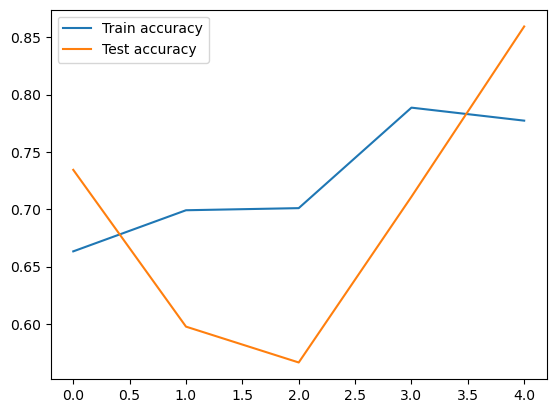

In [17]:
# plot the loss
plt.plot(tr_acc, label='Train accuracy')
plt.plot(te_acc, label='Test accuracy')
plt.legend()
plt.show()

## FCNN

In [45]:
class Net_FCN(nn.Module):
    def __init__(self, channels, feature_size):
        super().__init__()
        self.main = nn.Sequential(
            self.block(channels, feature_size, 3, 2, 1), # 300x300 --> 150x150
            self.block(feature_size, feature_size*2, 3, 2, 1), # 150x150 --> 75x75
            self.block(feature_size*2, feature_size*4, 3, 2, 1), # 75x75 --> 38x38
            self.block(feature_size*4, feature_size*8, 3, 2, 1), # 38x38 --> 19x19
            self.block(feature_size*8, feature_size*4, 3, 2, 1), # 19x19 --> 10x10
            self.block(feature_size*4, feature_size*2, 3, 2, 1), # 10x10 --> 5x5
            self.block(feature_size*2, feature_size, 3, 2, 1), # 5x5 --> 3x3
            nn.Conv2d(feature_size, 1, 3, 2, 0),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.main(x).squeeze()

    def block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

In [46]:
lr_FCN = 0.01

feature_size_FCN = 2

num_epochs_FCN = 5

with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
    with record_function("model_inference"):
        net_FCN = Net_FCN(channels, feature_size_FCN).to(device)

net_FCN.apply(weights_init)

criterion_FCN = nn.CrossEntropyLoss().to(device)

optimizer_FCN = torch.optim.Adam(net_FCN.parameters(), lr=lr_FCN)

pytorch_total_params_FCN = sum(p.numel() for p in net_FCN.parameters())
print("Total number of parameters FCN: ", pytorch_total_params_FCN)

Total number of parameters FCN:  3186


In [57]:
tr_loss = np.zeros((num_epochs_FCN))
te_loss = np.zeros((num_epochs_FCN))

tr_acc = np.zeros((num_epochs_FCN))
te_acc = np.zeros((num_epochs_FCN))

for epoch in range(num_epochs_FCN):

    train_loss = 0
    test_loss = 0
    
    train_acc = 0
    test_acc = 0

    net_FCN.train()
    
    for i, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        print(labels)
        optimizer_FCN.zero_grad(set_to_none=True)
        outputs = net_FCN(data)
        print(outputs)
        print(outputs.squeeze())
        print(outputs.shape, labels.shape)
        outputs = outputs.squeeze()
        print(outputs.shape, labels.shape)

#         print(outputs, labels)

        loss = F.binary_cross_entropy(outputs,  labels.type(torch.float32))
        loss.backward()
        optimizer_FCN.step()

        train_loss += loss.item()

        # compute the accuracy for this batch
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == labels).sum().item()
        accuracy = correct / len(labels)
        train_acc += accuracy
        
    net_FCN.eval()
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            labels = labels.unsqueeze(-1)
            
            outputs = net_FCN(data)
            loss = F.binary_cross_entropy(outputs,  labels.type(torch.float32))

            test_loss += loss.item()

            # compute the accuracy for this batch
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels).sum().item()
            accuracy = correct / len(labels)
            test_acc += accuracy

    # compute the average loss and accuracy for each epoch
    train_loss /= len(train_loader)
    test_loss /= len(test_loader)
    train_acc /= len(train_loader)
    test_acc /= len(test_loader)

    tr_loss[epoch] = train_loss
    te_loss[epoch] = test_loss
    tr_acc[epoch] = train_acc
    te_acc[epoch] = test_acc

    print(f"Epoch {epoch+1}/{num_epochs_FCN}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

tensor([1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
        1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0])
tensor([[[[0.6951]]],


        [[[0.8117]]],


        [[[0.2526]]],


        [[[0.7332]]],


        [[[0.7363]]],


        [[[0.7175]]],


        [[[0.6956]]],


        [[[0.5270]]],


        [[[0.7854]]],


        [[[0.7431]]],


        [[[0.1155]]],


        [[[0.6719]]],


        [[[0.8092]]],


        [[[0.3992]]],


        [[[0.6371]]],


        [[[0.2258]]],


        [[[0.5165]]],


        [[[0.4658]]],


        [[[0.4356]]],


        [[[0.1975]]],


        [[[0.1751]]],


        [[[0.3754]]],


        [[[0.7597]]],


        [[[0.5861]]],


        [[[0.5153]]],


        [[[0.1683]]],


        [[[0.4642]]],


        [[[0.4808]]],


        [[[0.6295]]],


        [[[0.4679]]],


        [[[0.4348]]],


        [[[0.4718]]],


        [[[0.25

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

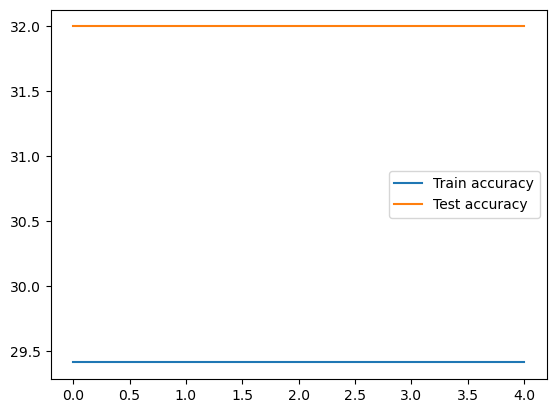

In [34]:
# plot the loss
plt.plot(tr_acc, label='Train accuracy')
plt.plot(te_acc, label='Test accuracy')
plt.legend()
plt.show()